In [1]:
# import torch
from pathlib import Path
import pandas as pd
import numpy as np
import cv2

In [18]:
path = Path("../")
data_path = path / "data"
train_images_path = data_path / "train_images"
test_images_path = data_path / "test_images"

# Dataframes

In [3]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


In [4]:
test_df = pd.read_csv(data_path / "test.csv")
test_df['path'] = test_df.id.apply(lambda x: f'{str(test_images_path)}/{x}.tiff')
test_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,path
0,10078,spleen,Hubmap,2023,2023,0.4945,4,../data/test_images/10078.tiff


# Functions

In [74]:
def mask2rle(mask):
    '''
    mask: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def maskPath2rle(img_path, rle):
    '''
    Funtion to probe if mask2rle is working
    '''
    img = cv2.imread(str(img_path), cv2.COLOR_BGR2RGB)
    mask = rle2mask(rle, img.shape)
    return mask2rle(mask)

def compare_rle(rle1, rle2):
    return rle1 == rle2

def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

# Sample

In [28]:
from random import randint
idx = randint(0, len(train_df) - 1)
idx = 1
sample_img_path = train_df.iloc[idx].path
sample_img_cv = cv2.imread(sample_img_path, cv2.COLOR_BGR2RGB)
type(sample_img_cv), sample_img_cv.shape, sample_img_cv.dtype, sample_img_cv.min(), sample_img_cv.max()

(numpy.ndarray, (3000, 3000, 3), dtype('uint8'), 12, 245)

In [24]:
sample_img_rle = train_df.iloc[idx].rle
type(sample_img_rle), len(sample_img_rle)

(str, 74424)

In [8]:
sample_img_rle_words = sample_img_rle.split()
type(sample_img_rle_words), len(sample_img_rle_words)

(list, 12614)

In [9]:
sample_img_cv_mask = rle2mask(sample_img_rle, sample_img_cv.shape)
type(sample_img_cv_mask), sample_img_cv_mask.shape, sample_img_cv_mask.dtype, sample_img_cv_mask.min(), sample_img_cv_mask.max()

(numpy.ndarray, (3000, 3000), dtype('uint8'), 0, 1)

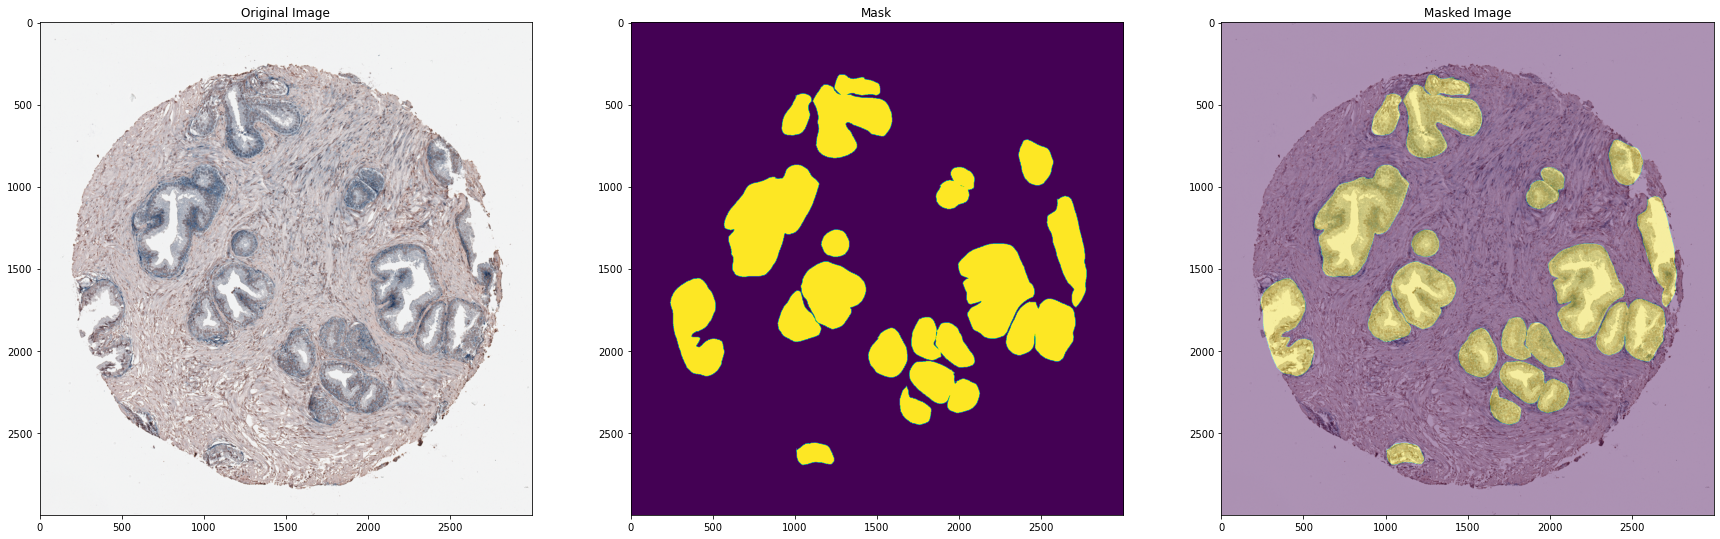

In [10]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_cv)
ax1.set_title('Original Image')
ax2.imshow(sample_img_cv_mask)
ax2.set_title('Mask')
ax3.imshow(sample_img_cv)
ax3.imshow(sample_img_cv_mask, alpha=0.4)
ax3.set_title('Masked Image')
plt.show()

# mask to rle

In [11]:
sample_img_rle_calc = mask2rle(sample_img_cv_mask.T)

In [12]:
sample_img_rle == sample_img_rle_calc

True

# rle calt to mask

In [13]:
sample_img_cv_mask_calc = rle2mask(sample_img_rle_calc, sample_img_cv.shape)
type(sample_img_cv_mask_calc), sample_img_cv_mask_calc.shape, sample_img_cv_mask_calc.dtype, sample_img_cv_mask_calc.min(), sample_img_cv_mask_calc.max()

(numpy.ndarray, (3000, 3000), dtype('uint8'), 0, 1)

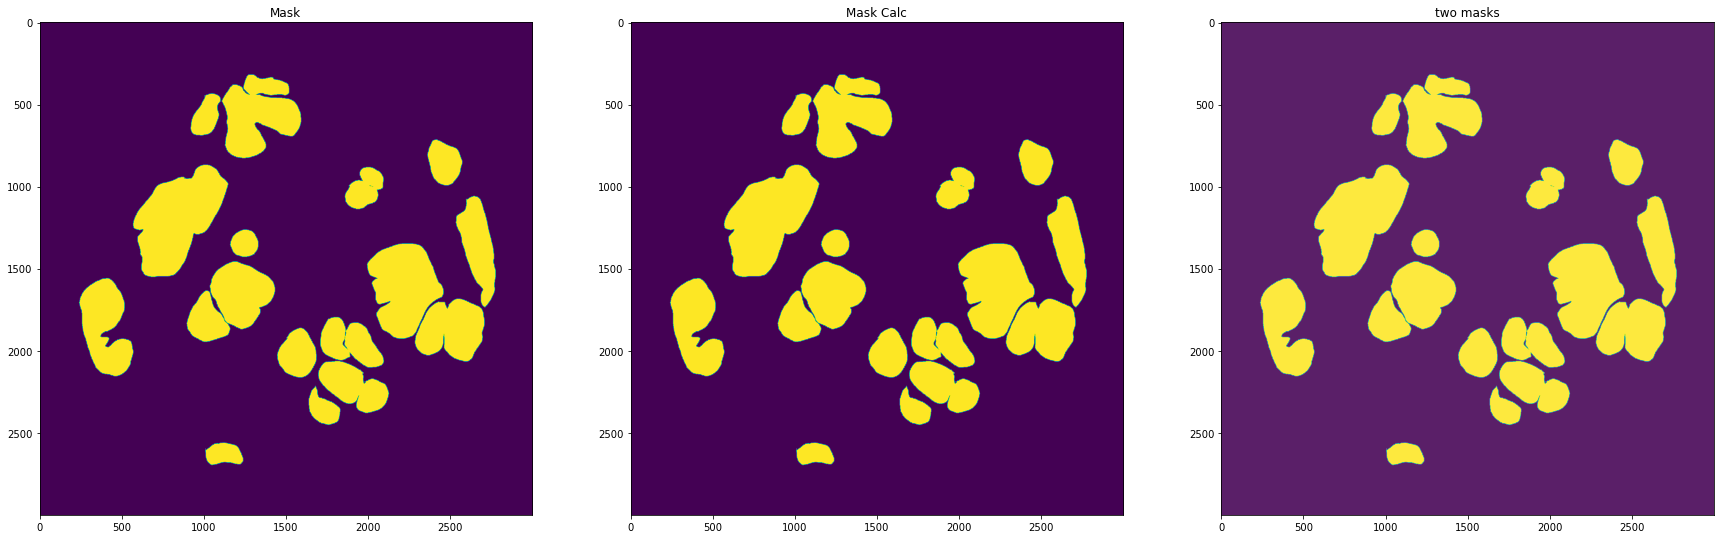

In [14]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_cv_mask)
ax1.set_title('Mask')
ax2.imshow(sample_img_cv_mask_calc)
ax2.set_title('Mask Calc')
ax3.imshow(sample_img_cv_mask, alpha=0.4)
ax3.imshow(sample_img_cv_mask_calc, alpha=0.8)
ax3.set_title('two masks')
plt.show()

# Add rle calc to dataframe

Añado una columna con el rle calculado por la función `maskPath2rle`. Esta función recibe un path de una imagen y un rle, obtiene una imagen de `CV` con el path, calcula una máscara con la imagen obtenida y el rle dado. Estas dos cosas sé que las hace bien.

Una vez tiene la máscara calcula un nuevo rle con la función `mask2rle`

In [72]:
train_df['rle_calc'] = train_df.apply(lambda x: maskPath2rle(x.path, x.rle), axis=1)
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path,rle_calc
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff,1459676 77 1462675 82 1465674 87 1468673 92 14...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff,715707 2 718705 8 721703 11 724701 18 727692 3...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff,1228631 20 1231629 24 1234624 40 1237623 47 12...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff,3446519 15 3449517 17 3452514 20 3455510 24 34...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff,478925 68 481909 87 484893 105 487863 154 4908...


Añado una columna que comprueba si el rle del dataframe y el rle calculado son iguales

In [75]:
train_df['rle_calc_ok'] = train_df.apply(lambda x: x.rle == x.rle_calc, axis=1)
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path,rle_calc,rle_calc_ok
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff,1459676 77 1462675 82 1465674 87 1468673 92 14...,True
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff,715707 2 718705 8 721703 11 724701 18 727692 3...,True
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff,1228631 20 1231629 24 1234624 40 1237623 47 12...,True
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff,3446519 15 3449517 17 3452514 20 3455510 24 34...,True
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff,478925 68 481909 87 484893 105 487863 154 4908...,True


Compruebo que todos los rle dados por el dataframe y el calculado son iguales

In [76]:
train_df.rle_calc_ok.value_counts()

True    351
Name: rle_calc_ok, dtype: int64